# Dask Bag

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы: 
* Макрушин С.В. Лекция "Map-Reduce"
* https://docs.dask.org/en/latest/bag.html
* Jesse C. Daniel. Data Science with Python and Dask. 

## Задачи для совместного разбора

## Лабораторная работа 12

__При решении данных задач не подразумевается использования циклов или генераторов Python в ходе работы с пакетами `numpy`, `pandas` и `dask`, если в задании не сказано обратного. Решения задач, в которых для обработки массивов `numpy`, структур `pandas` или структур `dask` используются явные циклы (без согласования с преподавателем), могут быть признаны некорректными и не засчитаны.__

В ходе выполнения все операции вычислений проводятся над `dask.bag` и средствами пакета `dask`, если в задании не сказано обратного. Переход от `dask.bag` к `pd.DataFrame` возможен исключительно для демонстрации результата в конце решения задачи. Если в задаче используются результаты выполнения предыдущих задач, то подразумевается, что вы используете результаты в виде `dask.bag` (то есть то, что было получено до вызова `compute`, а не после).

1\. В файлах архива `reviews_full.zip` находятся файлы, содержащие информацию об отзывах к рецептам в формате JSON Lines. Отзывы разделены на файлы в зависимости от оценки (например, в файле `reviews_1.json` находятся отзывы с оценкой 1). Считайте файлы из этого архива (предварительно разархивировав) в виде `dask.bag`. Преобразуйте текстовое содержимое файлов с помощью модуля `json`. Выведите на экран первые 5 элементов полученного `bag`.

In [1]:
import dask.bag as db
import json
path = 'C://Users//icom1//OneDrive - icom//Рабочий стол//TOBD_datasets//'
import re

In [3]:
files = [f'{path}reviews_{i}.json' for i in range(6)]

reviews = db.read_text(files).map(json.loads)

In [4]:
reviews.take(5)

({'user_id': 452355,
  'recipe_id': 292657,
  'date': '2016-05-08',
  'review': 'WOW!!! This is the best. I have never been able to make homemade enchiladas that taste like the Mexican restaurants. I made this last night for my family and they said they will never have enchiladas at the Mexican Restaurants again. Thanks for sharing.'},
 {'user_id': 329304,
  'recipe_id': 433404,
  'date': '2006-06-14',
  'review': 'This was good but the dressing needed something and I found it to be a little too sweet, next time I will experiment with some garlic and herbs and reduce the sugar slightly, thanks for sharing kcdlong!...Kitten'},
 {'user_id': 227932,
  'recipe_id': 2008187,
  'date': '1985-11-19',
  'review': 'Very good,it was a hit for my family. I used 6 cloves of garlic and had 1 lb beef and  Johnsonville sausage,1/2 lb hot and  1/2 lb honey garlic( which I wanted to use). That was a perfect combo for us. The sausage gave it nice flavor No guestion , I will be making this often.'},
 {'u

2\. Модифицируйте функцию разбора JSON таким образом, чтобы в каждый словарь c информацией об отзыве добавить ключ `rating`. Значение получите на основе названия файла (см. аргумент `include_path` функции `read_text`), использовав для этого регулярное выражение. При создании `bag` разбейте набор данных на сегменты размером 128 Мб (см. аргумент `blocksize`).  Выведите на экран первые 5 элементов полученного `bag`.

In [8]:
import re
patern = re.compile(r'reviews_(\d).json')
def read_json(f):
    file = json.loads(f[0])
    file['rating'] = int(patern.findall(f[1])[0])
    return file

reviews = db.read_text(files, include_path = True, blocksize='128MB').map(read_json)

In [10]:
reviews.take(5)

({'user_id': 452355,
  'recipe_id': 292657,
  'date': '2016-05-08',
  'review': 'WOW!!! This is the best. I have never been able to make homemade enchiladas that taste like the Mexican restaurants. I made this last night for my family and they said they will never have enchiladas at the Mexican Restaurants again. Thanks for sharing.',
  'rating': 0},
 {'user_id': 329304,
  'recipe_id': 433404,
  'date': '2006-06-14',
  'review': 'This was good but the dressing needed something and I found it to be a little too sweet, next time I will experiment with some garlic and herbs and reduce the sugar slightly, thanks for sharing kcdlong!...Kitten',
  'rating': 0},
 {'user_id': 227932,
  'recipe_id': 2008187,
  'date': '1985-11-19',
  'review': 'Very good,it was a hit for my family. I used 6 cloves of garlic and had 1 lb beef and  Johnsonville sausage,1/2 lb hot and  1/2 lb honey garlic( which I wanted to use). That was a perfect combo for us. The sausage gave it nice flavor No guestion , I will

3\. Посчитайте, сколько различных пользователей оставляли отзывы. Выведите это количество на экран.

In [12]:
unique_users = reviews.distinct(key='user_id').count()

unique_users.compute()

226570

4\. Создайте версию `bag` из задания 2, в которой сохранены только отзывы, оставленные в 2014 и 2015 годах. Посчитайте и выведите на экран долю, которую составляют отзывы, оставленные в 2014 и 2015 году, среди всех отзывов.

In [60]:
pattern = re.compile(r'2014|2015')

filtered = reviews.filter(lambda i: True if bool(pattern.findall(i['date']))==True else False)

filtered.count().compute()/reviews.count().compute()

0.08117811237929945

5\. Для отзывов, оставленных в мае 2013 года, выполните предобработку: 
   * приведите строки к нижнему регистру;
   * обрежьте пробельные символы в начале и конце строки;
   * удалите все символы, кроме английских букв и пробелов.
   
Посчитайте и выведите на экран среднюю длину этих отзывов после предобработки. Если текстовое содержимое отзыва отсутствует, считайте, что длина отзыва равна нулю.

In [18]:
pattern_date = re.compile(r'2013-05')
pattern_deleted = re.compile(r'[^\w]')

filtered_date = reviews.filter(lambda i: True if bool(pattern_date.findall(i['date']))==True else False)

mapped = filtered_date.map(
    lambda i: len(re.sub(pattern_deleted, '', i['review'].lower().strip(' '))) 
    if len(i['review']) > 0
    else 0).mean()

mapped.compute()

217.9038370600554

6\. Посчитайте, как часто встречается та или иная оценка:

   * в 2014 году;
   * в 2015 году.

Создайте `pd.DataFrame`, содержащий 2 столбца: `2014`, `2015` и 6 строк, имеющие индексы строк от 0 до 5. Дайте индексам строк имя `rating`. Выведите полученную таблицу на экран.

In [47]:
pat2014 = re.compile(r"2014")
pat2015 = re.compile(r"2015")

ser1 = reviews.filter(
    lambda i: True if bool(pat2014.findall(i['date']))==True else False).map(
    lambda i: i['rating']).frequencies(
).to_dataframe(
).compute(
)[1]

ser2 = reviews.filter(
    lambda i: True if bool(pat2015.findall(i['date']))==True else False).map(
    lambda i: i['rating']).frequencies(
).to_dataframe(
).compute(
)[1]

In [48]:
import pandas as pd
pd.concat([ser1, ser2], axis=1, keys=[2014, 2015])

,2014,2015
0,21136,21336
1,4344,4902
2,4507,4873
3,12865,13667
4,58433,60980
5,258832,269399


7\.  Перераспределите данные из исходного `bag` на $k, k=2, 16, 32, 64, 128$ частей. Для каждого разбиения измерьте время выполнения расчета среднего рейтинга. Визуализируйте зависимость времени выполнения функции от числа сегментов. Временем, затрачиваемым на вызов метода `repartition`, можно пренебречь. Для итерации по $k$ допускается использовать циклы.

In [51]:
k = [2**i for i in range(1,8)]
partitions = []
for i in k:
    partitions.append(reviews.repartition(i))

In [53]:
import time

times = []

for i in partitions:
    t0 = time.time()
    i.pluck('rating').mean().compute()
    t1 = time.time()
    times.append(t1-t0)

In [55]:
times

[507.882764339447,
 368.5459682941437,
 332.076464176178,
 272.0826110839844,
 99.17199969291687,
 444.43217849731445,
 580.2613332271576]

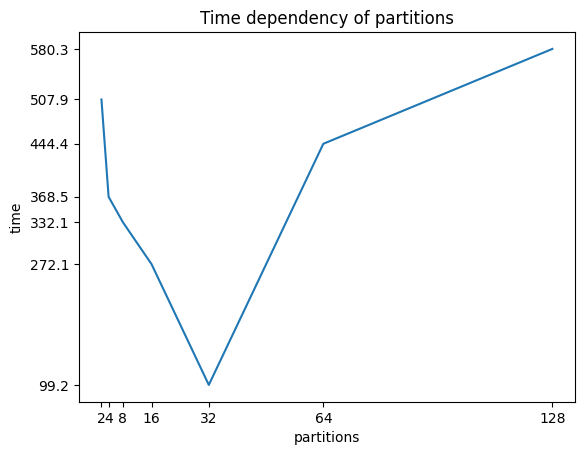

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 1)

ax.set_title('Time dependency of partitions')
ax.set_xlabel('partitions')
ax.set_ylabel('time')
ax.set_yticks(times)
ax.set_xticks(k)
ax.plot(k, times)
None

8\. Будем считать, что сегмент _плохо перемешан_, если в нем _подряд_ идет 5 или более отзывов, оставленных в один и тот же год. Воспользовавшись методом `map_partitions`, посчитайте и выведите на экран, сколько сегментов оказались _плохо перемешанными_ в `bag` из задачи 2. Также выведите на экран общее количество сегментов в `bag`, для которого производились расчеты.

9\. Будем считать, что сегмент _плохо перемешан_, если в нем подряд идет 5 или более отзывов, оставленных в один и тот же год. Воспользовавшись методом `reduction`, посчитайте и выведите на экран, сколько сегментов оказались _плохо перемешанными_ в `bag` из задачи 1. При реализации функций для свертки воспользуйтесь `functools.reduce`. 

10\. Используя метод `foldby`, подсчитайте и выведите на экран максимальную длину отзывов в зависимости от оценки `rating` в наборе, полученном в задании 2.